### 1. Pre-requisites

#### 1.1 Library Import
Code to import libraries

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import os, fnmatch
import torch
import torch.utils.data

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 1.2 Show Images function  
A light weight function to display and compare multiple images

In [0]:
def show_images(images, titles=[], figsize=(22,8), super_title='', title_y=0.75):
    fig, axes = plt.subplots(ncols=len(images), figsize=figsize)
    st=fig.suptitle(super_title, fontsize='14')
    st.set_y(title_y)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    for i,im in enumerate(images):
        axes[i].axis('off')
        axes[i].imshow(im, cmap='gray')
        if len(titles)!=0:
            image_title=titles[i]
        else:
            image_title='Image '+str(i+1)
        axes[i].set_title(image_title)

In [33]:
!ls -l /content/drive/Shared\ drives/stand_mapping/data/processed/packforest/training_chips/553915_5187734_1536_naip.tif

-r-------- 1 root root 743410 May  7 16:15 '/content/drive/Shared drives/stand_mapping/data/processed/packforest/training_chips/553915_5187734_1536_naip.tif'


#### 1.3 Data Check
Check whether data is loading correctly or not

In [0]:
train_data_path='/content/drive/Shared drives/stand_mapping/data/processed/packforest/training_chips/'

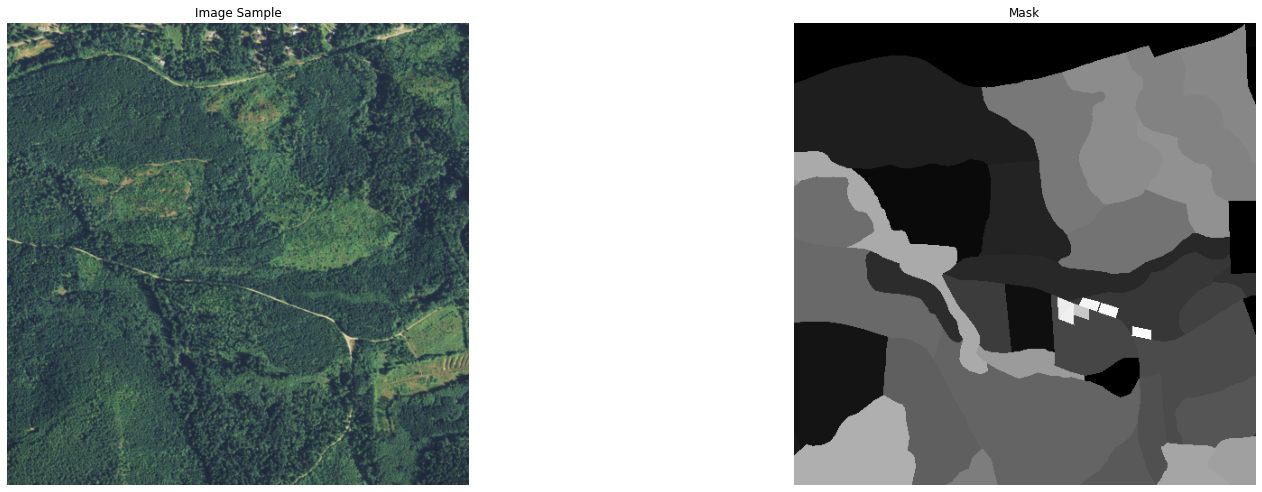

In [4]:
sample=plt.imread(train_data_path+'553915_5187734_1536_naip.tif')
sample_mask=plt.imread(train_data_path+'553915_5187734_1536_stand_mask.tif')
show_images([sample, sample_mask],['Image Sample','Mask'])

Separate out individual masks and display


In [0]:
obj_ids = np.unique(sample_mask)
obj_ids = obj_ids[1:]
masks = [np.array(sample_mask == idx) for idx in obj_ids]

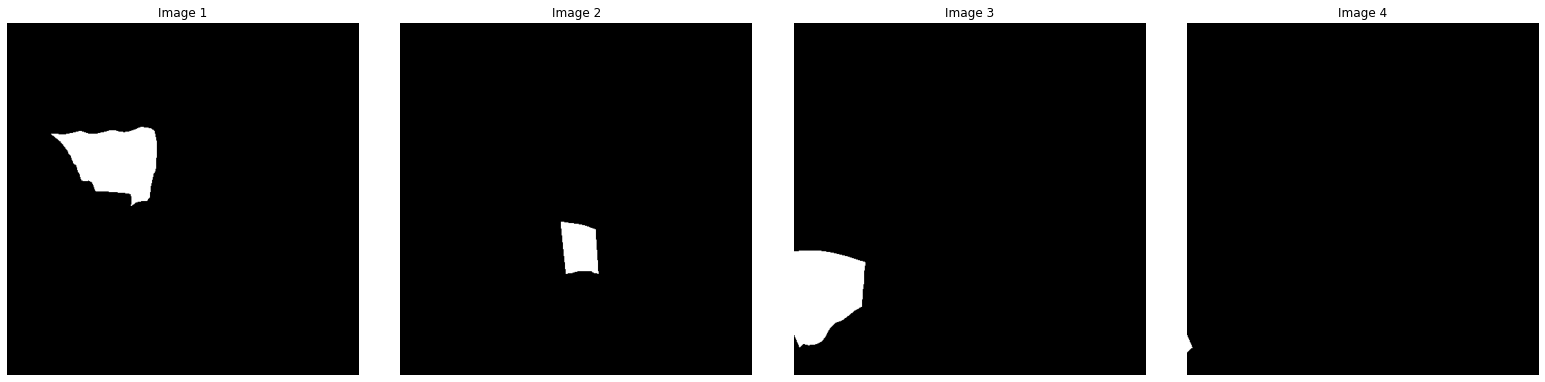

In [20]:
# for i in range(9):
#   show_images(masks[5*i:5*i+5])
show_images(masks[1:5])

### 2.0 Data Load
#### 2.1 Read Data

In [0]:
def get_files(root,pattern):
  return fnmatch.filter(os.listdir(root),'*naip*')

#### 2.2 PyTorch Dataset

The code below creates a dataset for Mask-RCnn Model of our project.  
**References:** 
1. https://pytorch.org/tutorials/beginner/data_loading_tutorial.html  
2. https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html   

**Dataset class**
torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

- `__len__` so that len(dataset) returns the size of the dataset.
- `__getitem__` to support the indexing such that dataset[i] can be used to get ith sample  

Let’s create a dataset class for our face landmarks dataset. We will read the image paths in `__init__` but leave the reading of images to `__getitem__`. This is memory efficient because all the images are not stored in the memory at once but read as required.

Sample of our dataset will be a dict {'image': image, 'landmarks': landmarks}. Our dataset will take an optional argument transform so that any required processing can be applied on the sample. We will see the usefulness of transform in the next section.

In [0]:
class StandMappingDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms=None):
    self.root = root
    self.transforms = transforms
    # load all image files, sorting them to
    # ensure that they are aligned
    self.imgs = list(sorted(get_files(root,'*naip*')))
    self.masks = list(sorted(get_files(root,'*stand_mask*')))

  def __getitem__(self, idx):
    # load images ad masks
    img_path = self.root+self.imgs[idx]
    mask_path = self.root+self.masks[idx]
    img = Image.open(img_path).convert("RGB")
    # note that we haven't converted the mask to RGB,
    # because each color corresponds to a different instance
    # with 0 being background
    mask = Image.open(mask_path)

    mask = np.array(mask)
    
    # instances are encoded as different colors
    obj_ids = np.unique(mask)
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]
    
    # split the color-encoded mask into a set
    # of binary masks
    masks = [np.array(mask == idx) for idx in obj_ids]

    # get bounding box coordinates for each mask
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
      pos = np.where(masks[i])
      
      xmin = np.min(pos[1])
      xmax = np.max(pos[1])
      ymin = np.min(pos[0])
      ymax = np.max(pos[0])
      boxes.append([xmin, ymin, xmax, ymax])

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    # there is only one class
    labels = torch.ones((num_objs,), dtype=torch.int64)
    masks = torch.as_tensor(masks, dtype=torch.uint8)

    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
        img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.imgs)

In [0]:
dataset = StandMappingDataset(train_data_path)

In [18]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=512x512 at 0x7F18921FDCC0>,
 {'area': tensor([2.4435e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05,
          2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05,
          2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05,
          2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05,
          2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05,
          2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05,
          2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05,
          2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05,
          2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05,
          2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05,
          2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05, 2.6112e+05,
          2.6112e+05, 2.